In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

In [76]:
# Load generated graphs (each includes labels)
loaded_data_list = torch.load('graph_list.pt')
print("Loaded ", len(loaded_data_list), " data")


C:\Users\adamp\AppData\Local\Temp\ipykernel_37048\2856410996.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data_list = torch.load('graph_list.pt')


Loaded  5412  data


In [84]:
# Normalize features and labels
y_labels = [np.array(graph.y) for graph in loaded_data_list]
X_features = [np.array(graph.x) for graph in loaded_data_list]
y_labels = np.concatenate(y_labels)
X_features = np.concatenate(X_features)

y_mean = np.mean(y_labels, axis=0)
y_std = np.std(y_labels, axis=0)
X_mean = np.mean(X_features, axis=0)
X_std = np.std(X_features, axis=0)

graphs_normalized = loaded_data_list.copy()
for i in range(len(loaded_data_list)):
    graphs_normalized[i].x = (graphs_normalized[i].x-X_mean)/X_std
    #graphs_normalized[i].y = (graphs_normalized[i].y-y_mean)/y_std

# Do test-train split on graphs
train_graphs, test_graphs = train_test_split(graphs_normalized, test_size=0.2)

# Create data loaders to aggregate batches
train_loader = DataLoader(train_graphs, batch_size=10)
test_loader = DataLoader(test_graphs, batch_size=10)

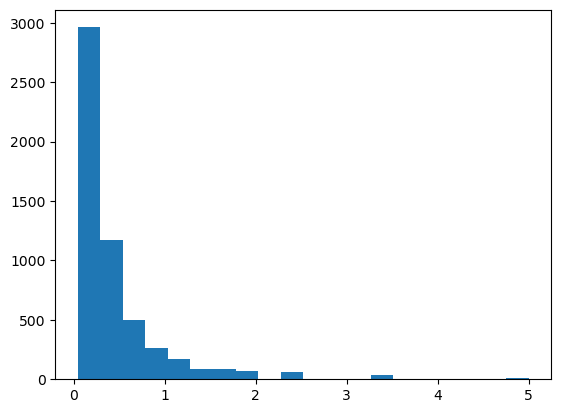

[0.3869839  0.42304763 0.4023125 ]


In [83]:
plt.hist(np.linalg.norm(y_labels, axis=1), bins=20)
plt.show()
print(y_std)

In [85]:
class GCNN_Model(torch.nn.Module):
    """
    Model used to predict jump direction and probabbility from a grpah representing nearby atoms
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN_Model, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        """
        Forward pass of GCN

        Parameters: 
        - data (torch_geometric.data.Data): input graph including node and edge features

        Returns:
        - x (torch.tensor(batch,3)): output predictions for direction and probability of jump
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # TODO: add edge attributes

        # GNN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # Global Pooling
        x = global_mean_pool(x, batch)  # Aggregates node features to graph level

        # Fully Connected Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # Predicts 3 continuous values
        x = F.relu(x)

        return x


In [86]:
class ExponentialDirLoss(torch.nn.Module):
    """
    Custom loss function representing the maximum log liklihood of an exponential distribution as well as the direction angle error
    """
    def __init__(self, lam=1.0):
        """ 
        Parameters: 
        - lam (float): weighting of angle term in loss function, zero ignores angle, use a number <1e-2 ideally
        """
        super(ExponentialDirLoss, self).__init__()
        self.lam = lam # weighting of angle error

    def forward(self, predictions, labels):
        """
        Compute custom loss function that combines the probability of hopping and the hopping direction

        Parameters: 
        - predictions (torch.tensor(batch,3)): model output predictions
        - labels (torch.tensor(batch,3)): label of hop direction weighted by 1/residence time [1/ps]

        Returns:
        - total_error (torch.tensor(1)): output predictions for direction and probability of jump
        """

        pred_mag= torch.norm(predictions, dim=1)
        target_mag = torch.norm(labels, dim=1)
        mag_error = pred_mag/target_mag - torch.log(pred_mag) # 

        angle_error = torch.acos((predictions*labels).sum(dim=1)/(pred_mag*target_mag))
        
        total_error = torch.mean(mag_error + self.lam*angle_error)


        return total_error


In [87]:
def performance_metrics(predictions, labels):
        """
        FReturns practical performance metrics

        Parameters: 
        - predictions (torch.tensor(batch,3)): model output predictions
        - labels (torch.tensor(batch,3)): label of hop direction weighted by 1/residence time [1/ps]

        Returns:
        - mag_error (torch.tensor(1)): average difference in probability [1/ps]
        - angle_error (torch.tensor(1)): average angle between predicted and actual vectors [rad]
        """
        
        # Average difference in probability [1/ps]
        pred_mag= torch.norm(predictions, dim=1)
        target_mag = torch.norm(labels, dim=1)
        mag_error = torch.abs(pred_mag - target_mag)
        mag_error = torch.mean(mag_error).detach().numpy()

        # Angle between predicted and actual vectors
        angle_error = torch.acos((predictions*labels).sum(dim=1)/(pred_mag*target_mag))
        angle_error = torch.mean(angle_error).detach().numpy()

        return mag_error, angle_error

In [91]:
# Initialize the model
model = GCNN_Model(loaded_data_list[0].num_node_features, 16, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, )
criterion = ExponentialDirLoss(lam=0.0) 

In [89]:
def train():
    """
    Mini Batch training iterates through all training batches and update the model

    Returns:
    - total_loss (np.float64): average loss for each mini batch
    - mag_errors (np.float64): average probability error over data set [1/ps]
    - angle_errors (np.float64): average angle error over data set [rad]
    """
    model.train()
    total_loss = []
    mag_errors = []
    angle_errors = []
    # Mini-batch
    for data in train_loader:
        # Forward Pass
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        # Backward Pass
        loss.backward()
        # Update
        optimizer.step()
        # Compute Losses
        total_loss.append(loss.detach().numpy())
        # Log metrics
        mag_error, angle_error = performance_metrics(out, data.y)
        mag_errors.append(mag_error) 
        angle_errors.append(angle_error) 
    
    # Report average of each performance metric
    total_loss = np.mean(np.array(total_loss))
    mag_errors = np.mean(np.array(mag_errors))
    angle_errors = np.mean(np.array(angle_errors))


    return total_loss, mag_errors, angle_errors
    

# Test the model
def test():
    """
    Calculates performance metrics on a test set

    Returns:
    - mag_errors (np.float64): average probability error over data set [1/ps]
    - angle_errors (np.float64): average angle error over data set [rad]
    
    """
    model.eval()
    mag_errors = []
    angle_errors = []
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            label = data.y
            mag_error, angle_error = performance_metrics(out, label)
            mag_errors.append(mag_error) # Units (1/ps)
            angle_errors.append(angle_error) # Units (radians)
    
    # Report average of each performance metric
    mag_errors = np.mean(np.array(mag_errors))
    angle_errors = np.mean(np.array(angle_errors))

    return mag_errors, angle_errors



In [92]:
# Training loop
epochs = 51

# Report initial metric on untrained model
mag_error, angle_error = test()
print(f'Initial Error:  Mag Error (1/ps): {mag_error:.4f}, Angle Error (deg): {(180/3.14)*angle_error:.4f}')

loss_log = []
mag_train_log = []
mag_test_log = []
angle_train_log = []
angle_test_log = []
for epoch in range(epochs):
    loss, mag_err_train, angle_err_train = train()
    mag_err_test, angle_err_test = test()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Mag Error (1/ps): {mag_err_test:.4f}, Angle Error (deg): {(180/3.14)*angle_err_test:.4f}')
    # Logging
    loss_log.append(loss)
    mag_train_log.append(mag_err_train)
    mag_test_log.append(mag_err_test)
    angle_train_log.append((180/3.14)*angle_err_train) # degrees
    angle_test_log.append((180/3.14)*angle_err_test) # degrees

Initial Error:  Mag Error (1/ps): 1.0313, Angle Error (deg): 89.2975
Epoch 1/51, Loss: 1.7547, Mag Error (1/ps): 0.7408, Angle Error (deg): 89.0830
Epoch 2/51, Loss: 1.7429, Mag Error (1/ps): 0.7438, Angle Error (deg): 89.0830
Epoch 3/51, Loss: 1.7448, Mag Error (1/ps): 0.7428, Angle Error (deg): 89.0830
Epoch 4/51, Loss: 1.7463, Mag Error (1/ps): 0.7409, Angle Error (deg): 89.0830
Epoch 5/51, Loss: 1.7473, Mag Error (1/ps): 0.7400, Angle Error (deg): 89.0830
Epoch 6/51, Loss: 1.7480, Mag Error (1/ps): 0.7397, Angle Error (deg): 89.0830
Epoch 7/51, Loss: 1.7484, Mag Error (1/ps): 0.7396, Angle Error (deg): 89.0830
Epoch 8/51, Loss: 1.7487, Mag Error (1/ps): 0.7395, Angle Error (deg): 89.0830
Epoch 9/51, Loss: 1.7488, Mag Error (1/ps): 0.7395, Angle Error (deg): 89.0830
Epoch 10/51, Loss: 1.7489, Mag Error (1/ps): 0.7395, Angle Error (deg): 89.0830
Epoch 11/51, Loss: 1.7489, Mag Error (1/ps): 0.7395, Angle Error (deg): 89.0830
Epoch 12/51, Loss: 1.7490, Mag Error (1/ps): 0.7395, Angle E

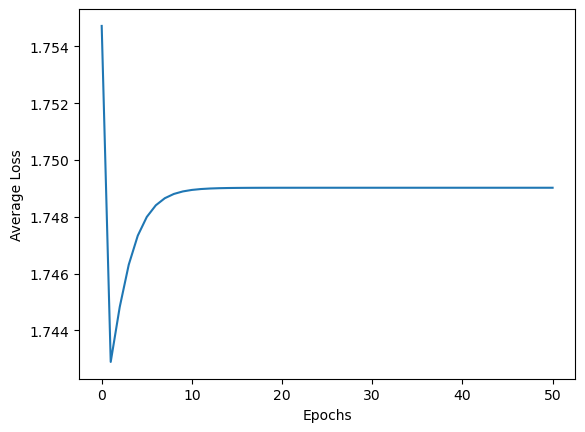

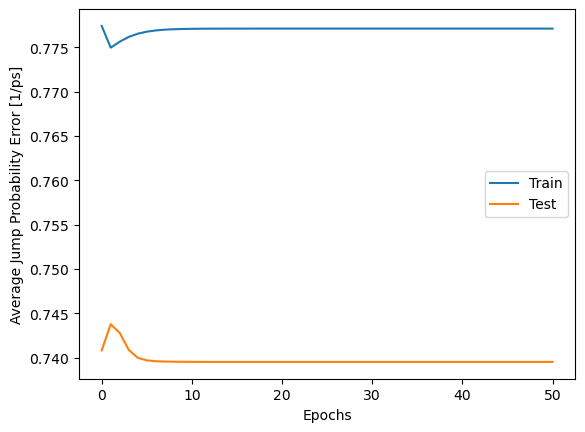

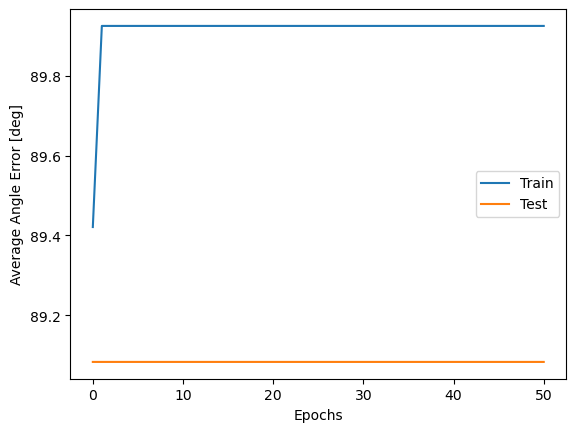

In [94]:


plt.plot(range(epochs), loss_log)
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
#plt.ylim([0,4])
plt.show()

plt.plot(range(epochs), mag_train_log)
plt.plot(range(epochs), mag_test_log)
plt.legend(["Train", "Test"])
plt.xlabel("Epochs")
plt.ylabel("Average Jump Probability Error [1/ps]")
plt.show()

plt.plot(range(epochs), angle_train_log)
plt.plot(range(epochs), angle_test_log)
plt.legend(["Train", "Test"])
plt.xlabel("Epochs")
plt.ylabel("Average Angle Error [deg]")
plt.show()


In [ ]:
""